In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
import copy
import time

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
#https://docs.google.com/spreadsheets/d/1OOvlG0v6LL4mv7jLRyGLWMlNZ52SYoXJ/edit?usp=sharing&ouid=103817356813989391472&rtpof=true&sd=true
downloaded = drive.CreateFile({'id':"1OOvlG0v6LL4mv7jLRyGLWMlNZ52SYoXJ"})   # replace the id with id of file you want to access
downloaded.GetContentFile('CMT1.xlsx')        # replace the file name with your file

In [5]:
df = pd.read_excel("CMT1.xlsx", sheet_name="Лист1")

In [6]:
df = df.set_index('num')

In [7]:
df.columns

Index(['X', 'Y', 'count_product'], dtype='object')

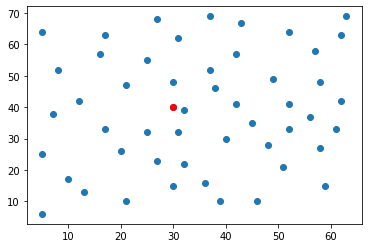

In [8]:
plt.scatter(df.X, df.Y)
plt.scatter(df.X[1], df.Y[1], color='r')
plt.show()

In [20]:
len(df.X)

51

### Last 

In [29]:
def knn_method(m, num_cars, num_customer, count_product,Q):
    cars= [i for i in range(num_cars)]

    track_of_car = []#записываем треки машин 
    for i in range(num_cars):
        track_of_car.append([0])

    metki = np.zeros((num_cars, num_customer, num_customer))#метки где была каждая машина (0 и 1)

    M = m.copy()

    for i in range(len(m)):
        for j in range(len(m[i])):
            if m[i][j]==0:
                m[i][j]=np.inf


    rez_distance = 0
    distance = m.copy()
    distance[:,0] = np.inf #чтобы не вернулись на склад
    geo_cars = np.zeros(len(cars))#нахождение машины в данный момент
    product_cars = [Q for i in cars]#наполненность машины

    while True:
        for i in cars:
            now=int(geo_cars[i])
            geo=np.argmin(distance[now])#едем в ближайшую точку
            if product_cars[i] >= count_product[geo]: #если хватает товаров
                product_cars[i] = product_cars[i]-count_product[geo] #обновляем наполненность машины
                distance[:,geo] = np.inf #чтобы больше не ехать в эту точку
                geo_cars[i] = geo #меняем местоположение машины
                track_of_car[i].append(geo) #добавляем в трек
                metki[i][now][geo]=1 #обновляем метки 
            else: #если не хватает товаров то едем на склад
                metki[i][now][0]=1
                now=0
                track_of_car[i].append(now)
                product_cars[i]=Q #полная заполненность
                geo_cars[i]=0

            if np.isinf(distance.min()): #если все проехали 
                for j in range(len(geo_cars)):
                    if int(geo_cars[j])!=0:
                        metki[j][int(geo_cars[j])][0]=1 
                        track_of_car[j].append(0) #последняя точка в треке склад
                rez_distance = np.sum([np.multiply(metki[k],M) for k in range(len(metki))]) #получаем итоговую сумму по всем трекам
                return metki,rez_distance,track_of_car

In [30]:
a = df[['X', 'Y']].values
m = np.linalg.norm(a[None] - a[:, None], axis=-1)
dist_for_tabu = m.copy()
num_cars=5
Q=160
customer_product = list(df.count_product)
num_customer = len(df.X)

cars_and_metki, distance, track_of_car = knn_method(m, num_cars, num_customer,customer_product,Q)
print(distance)

713.703040143


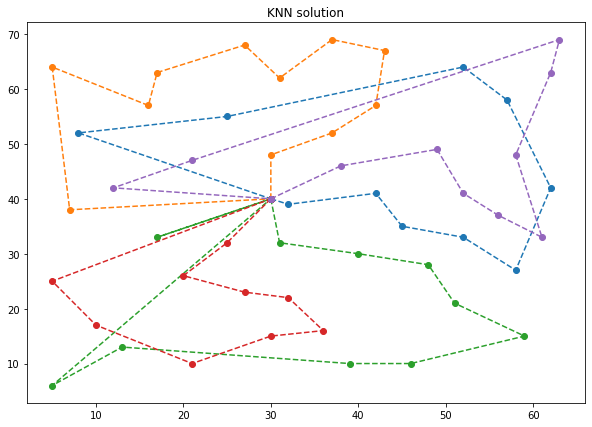

In [14]:
fig = plt.figure(figsize=(10,7))
for i in range(len(track_of_car)):
    plt.plot(df.iloc[track_of_car[i]].X.values, df.iloc[track_of_car[i]].Y.values,'o--')
plt.title('KNN solution')
plt.show()

Поиск с запретами (вар1)

In [11]:
def delete_null_in_center(tr): #убираем нули в треках
    tr = [i for i in tr if i != 0]
    tr.append(0)
    tr.insert(0,0)
    return tr

In [10]:
def make_new_track(track, q, prod,dist_for_tabu): #для добавления поездки на склад при необходимости
    car_capacity=q
    new_track = [0]
    dist = 0
    for i in range(len(track)-1):
        row = track[i]
        col = track[i+1]
        q_ = car_capacity-prod[col]
        if q_ >= 0:
            new_track.append(col)
            car_capacity = q_
            dist += dist_for_tabu[row][col]
        elif q_ < 0:
            col=0
            new_track.append(col)
            dist += dist_for_tabu[row][col]
            row = 0
            col = track[i+1]
            car_capacity = q
            new_track.append(col)
            q_ = car_capacity-prod[col]
            car_capacity = q_
            dist += dist_for_tabu[row][col]
    return dist, new_track

In [12]:
def random_new_track_and_dist(track_of_car, distance, q, customer_product,dist_for_tabu, n_changes):
    new_track_of_car = copy.deepcopy(track_of_car)
    for _ in range(n_changes):
        n1,n2 = random.sample(range(1,len(customer_product)-1), 2)
        for i in range(len(new_track_of_car)):
            for j in range(len(new_track_of_car[i])):
                if new_track_of_car[i][j]==n1:
                    new_track_of_car[i][j]=n2
                elif new_track_of_car[i][j]==n2:
                    new_track_of_car[i][j]=n1

    new_track_of_car_full = []
    for i in range(len(new_track_of_car)):
        new_track_of_car_full.append(delete_null_in_center(new_track_of_car[i]))

    new_track = []
    new_dist = 0
    for i in range(len(new_track_of_car_full)):
        dist0, new_track_of_car0 = make_new_track(new_track_of_car_full[i], q, customer_product,dist_for_tabu)
        new_track.append(new_track_of_car0)
        new_dist += dist0
    return new_track, new_dist

In [16]:
Tabu_metki = []
Tabu_metki.append(track_of_car)
best_solution_track = track_of_car
best_solution_distance = distance


start_time=time.time()
counter = 0
while (time.time() - start_time) < 0.5*60:
    new_track, new_dist = random_new_track_and_dist(best_solution_track, 
                                                    best_solution_distance, 
                                                    Q, 
                                                    customer_product,
                                                    dist_for_tabu,
                                                    counter // 5000 + 1)
    if new_track in Tabu_metki:
        print('new_track in tabu')
        continue
    counter += 1
    if new_dist < best_solution_distance:
        best_solution_track = new_track
        best_solution_distance = new_dist
        print(new_track,new_dist)
        counter = 0

[[0, 46, 11, 38, 9, 30, 21, 20, 3, 48, 23, 0], [0, 27, 1, 22, 28, 31, 8, 26, 7, 24, 43, 25, 0], [0, 12, 5, 49, 10, 39, 33, 45, 19, 40, 0, 18, 0], [0, 47, 4, 17, 37, 15, 44, 42, 41, 13, 0], [0, 32, 2, 16, 50, 34, 29, 35, 36, 6, 14, 0]] 710.0835154116239
[[0, 46, 11, 38, 9, 30, 21, 20, 3, 48, 23, 0], [0, 27, 1, 22, 28, 31, 8, 26, 7, 24, 43, 25, 0], [0, 12, 5, 49, 10, 39, 33, 45, 19, 40, 0, 47, 0], [0, 18, 4, 17, 37, 15, 44, 42, 41, 13, 0], [0, 32, 2, 16, 50, 34, 29, 35, 36, 6, 14, 0]] 704.5581969134043
[[0, 46, 11, 5, 9, 30, 21, 20, 3, 48, 23, 0], [0, 27, 1, 22, 28, 31, 8, 26, 7, 24, 43, 25, 0], [0, 12, 38, 49, 10, 39, 33, 45, 19, 40, 47, 0], [0, 18, 4, 17, 37, 15, 44, 42, 41, 13, 0], [0, 32, 2, 16, 50, 34, 29, 35, 36, 6, 14, 0]] 699.7539404262269
[[0, 46, 11, 5, 9, 30, 21, 20, 3, 48, 23, 0], [0, 27, 1, 22, 28, 31, 8, 26, 7, 43, 24, 25, 0], [0, 12, 38, 49, 10, 39, 33, 45, 19, 40, 47, 0], [0, 18, 4, 17, 37, 15, 44, 42, 41, 13, 0], [0, 32, 2, 16, 50, 34, 29, 35, 36, 6, 14, 0]] 685.54172382

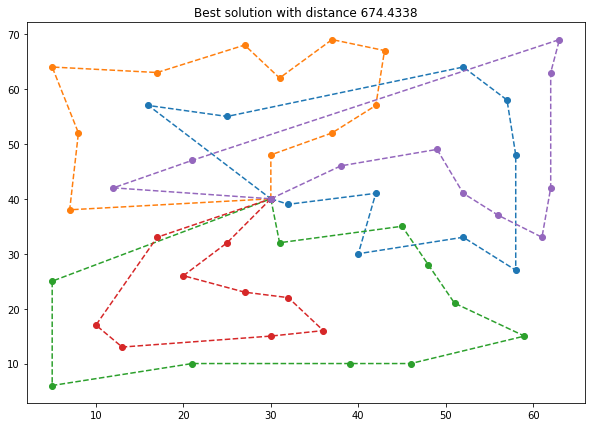

In [17]:
fig = plt.figure(figsize=(10,7))
for i in range(len(best_solution_track)):
    plt.plot(df.iloc[best_solution_track[i]].X.values, df.iloc[best_solution_track[i]].Y.values,'o--')
plt.title(('Best solution with distance '+str(np.round(best_solution_distance,4))))
plt.show()

поиск с запретами(вар2)

In [18]:
def random_new_track_and_dist_2(track_of_car, distance, q, customer_product,dist_for_tabu, n_changes):
    for i in range(len(track_of_car)):
        track_of_car[i] = delete_null_in_center(track_of_car[i])
    n_track_of_car = copy.deepcopy(track_of_car)
    for _ in range(n_changes):
        arr_big = np.empty((num_cars, len(customer_product) * 3 // num_cars))
        arr_big.fill(np.nan)
        for i, ar in enumerate(n_track_of_car):
            idxs = np.random.choice(range(1, arr_big.shape[1]-1), len(ar)-2, replace=False)
            idxs.sort()
            arr_big[i][idxs] = ar[1:-1]
            arr_big[i][[0, -1]] = ar[0], ar[-1]

        while True:
            row1,row2 = random.choices([i for i in range(1,len(arr_big))], k=2)
            col1,col2 = random.choices([i for i in range(1,len(arr_big[0]))], k=2)
            if not (arr_big[row1][col1]==arr_big[row2][col2] or 
                    (np.isnan(arr_big[row1][col1]) and 
                    np.isnan(arr_big[row2][col2]))):
                break
        arr_big[row1][col1], arr_big[row2][col2] = arr_big[row2][col2], arr_big[row1][col1]

        n1=arr_big[row1][col1]
        n2=arr_big[row2][col2]
        new_track_of_car = []
        for i, ar in enumerate(arr_big):
            new_track_of_car.append(ar[~np.isnan(ar)].astype(np.int64).tolist())

    new_track_of_car_full = []
    for i in range(len(new_track_of_car)):
        new_track_of_car_full.append(delete_null_in_center(new_track_of_car[i]))

    new_track = []
    new_dist = 0
    for i in range(len(new_track_of_car_full)):
        dist0, new_track_of_car0 = make_new_track(new_track_of_car_full[i], q, customer_product,dist_for_tabu)
        new_track.append(new_track_of_car0)
        new_dist += dist0
    return new_track, new_dist

In [19]:
Tabu_metki = []
Tabu_metki.append(track_of_car)
best_solution_track = track_of_car
best_solution_distance = distance


start_time=time.time()
counter = 0
while (time.time() - start_time) < 0.5*60:
    new_track, new_dist = random_new_track_and_dist_2(best_solution_track, 
                                                    best_solution_distance, 
                                                    Q, 
                                                    customer_product,
                                                    dist_for_tabu,
                                                    counter // 30000 + 1)
    if new_track in Tabu_metki:
        print('new_track in tabu')
        continue
    counter += 1
    if new_dist < best_solution_distance:
        best_solution_track = new_track
        best_solution_distance = new_dist
        print(new_track,new_dist)
        counter = 0

[[0, 46, 11, 38, 9, 30, 21, 20, 3, 48, 24, 0], [0, 27, 1, 22, 28, 31, 8, 26, 7, 23, 43, 25, 0], [0, 12, 5, 49, 10, 39, 33, 45, 19, 40, 0, 18, 0], [0, 47, 4, 17, 37, 15, 44, 42, 41, 13, 0], [0, 32, 2, 16, 50, 34, 29, 35, 36, 6, 14, 0]] 713.7030401429998
[[0, 46, 11, 38, 9, 30, 21, 20, 3, 48, 24, 0], [0, 27, 1, 22, 28, 31, 8, 26, 7, 23, 43, 25, 0], [0, 12, 5, 49, 10, 39, 33, 45, 19, 40, 0, 18, 14, 0], [0, 47, 4, 17, 37, 15, 44, 42, 41, 13, 0], [0, 32, 2, 16, 50, 34, 29, 35, 36, 6, 0]] 710.3399713337578
[[0, 46, 11, 38, 9, 30, 21, 20, 3, 48, 24, 0], [0, 27, 1, 22, 28, 31, 8, 26, 7, 23, 43, 25, 0], [0, 12, 5, 49, 10, 39, 33, 45, 19, 40, 14, 0], [0, 47, 4, 17, 37, 15, 44, 42, 41, 13, 0], [0, 32, 2, 16, 50, 34, 29, 35, 36, 0, 18, 6, 0]] 705.5955938295568
[[0, 46, 11, 38, 9, 30, 21, 20, 3, 48, 24, 0], [0, 27, 1, 22, 28, 31, 8, 26, 7, 23, 43, 25, 0], [0, 12, 5, 49, 10, 39, 33, 45, 19, 40, 0], [0, 47, 4, 17, 37, 15, 44, 42, 41, 13, 14, 0], [0, 32, 2, 16, 50, 34, 29, 35, 36, 0, 18, 6, 0]] 700.35

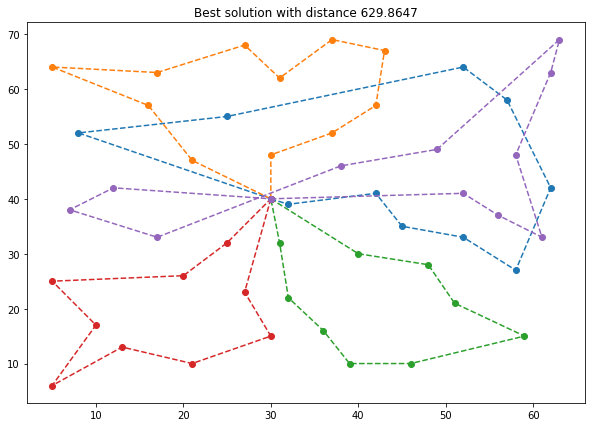

In [31]:
fig = plt.figure(figsize=(10,7))
for i in range(len(best_solution_track)):
    plt.plot(df.iloc[best_solution_track[i]].X.values, df.iloc[best_solution_track[i]].Y.values,'o--')
plt.title(('Best solution with distance '+str(np.round(best_solution_distance,4))))
plt.show()